density of number of neighbours
sparsity

Q:  is QOT automatically adjusting “number of neighbors” to the local density

todo: 
fix sigma = 1.0

plot “local density” vs “number of neighbors"

find an example where kNN with fixed k fails

where people use variable k

To try:
adjust the density along the arm


In [1]:
using Distributed, SharedArrays
addprocs(32)

@everywhere using LinearAlgebra, SparseArrays, StatsBase, Distances, IterativeSolvers
@everywhere using NearestNeighbors, OptimalTransport, MultivariateStats
@everywhere using Distributed, SharedArrays

using Plots
# using PyPlot
using LightGraphs, GraphPlot
using MLDatasets
# using Cairo, Compose
using NPZ

@everywhere include("util.jl")


In [2]:

#Given the number of nodes, the known labels,
#and the proportion of labels to sample, returns
#prop*N selected indices and labels.
#
#PARAMS:
#N: The number of nodes
#labels_all: A label corresponding to each node
#prop: The proportion of nodes to sample #NOT IMPLEMENTED
#
#RETURNS:
#ink_idx: An array of indices of selected nodes
#ink_color: Colors corresponding to the selected nodes
@everywhere function sample_labels(N, labels_all, prop)
    #Sample nodes for which we assume labels are known
    ink_idx = sample(1:N, Int(floor(prop*N)), replace = true) #Get the indices of the nodes
    sort!(ink_idx)
    ink_color = labels_all[ink_idx]  #Get the corresponding labels

    return ink_idx, ink_color
end

#Makes selection matrices S, P, Q, and an indicator vector
#
#PARAMS:
#ink_idx: The indices of the selected nodes
#ink_color: The label of the selected notes
#N: The number of nodes
#K: The number of labels
#
#RETURNS:
#ink_ind: A indicator vector of all nodes with 1 when a node is selected
#S: A diagonal matrix of all nodes with 1 when a node is selected
#P: A selection matrix where labelled cells are marked in their corresponding color column
#Q: A likelihood matrix for nodes being in a class (initialized to 0)
@everywhere function make_selection_matrices(ink_idx, ink_color, N, K)
    #Mark selected nodes as true, and all others false (indicator)
    ink_ind = zeros(Bool, N) 
    ink_ind[ink_idx] .= true

    # label selection matrix
    S = sparse(ink_idx, ink_idx, 1.0, N, N) #A diag matrix with ones on labelled nodes
    P = sparse(ink_idx, ink_color, 1.0, N, K) #A selection matrix where labelled cells are marked in their corresponding color colum
    Q = spzeros(N, K) #A likelihood matrix for nodes being in a class
    
    return ink_ind, S, P, Q
end

#Creates a cost matrix for optimal transport and
#target and source histograms.
#
#PARAMS:
#X: Coordinates of points in R^2
#
#RETURNS:
#C: A euclidean cost matrix b/w nodes
#μ: A uniform source histogram on nodes
#ν: A uniform target histogram on nodes
@everywhere function make_ot_params(X)
    C = pairwise(SqEuclidean(), X, X, dims=1) #Euclidean distance between nodes
    C[diagind(C)] .= Inf #No self edges allowed

    μ = ones(size(X, 1)) #Uniform distribution on nodes
    ν = ones(size(X, 1))
    
    return C, μ, ν
end

@everywhere function knnWeight(k, C, X, N, σ = 0.5)

    knn_idxs, knn_dists = knn( KDTree(X'), X', k, true)

    # adjacency matrix
    inds = vcat(Int.(ones(k)*collect(1:N)')...)
    A = sparse(inds, vcat(knn_idxs...), 1, N, N)

    inds_sym = A+A'.>0
    K = spzeros(N, N)
#     σ = 0.5
#     TODO: vary \sigma

    K[inds_sym] = exp.(-C[inds_sym].^2 / σ)

    d = spdiagm(0 => sum(K, dims=1)[1, :].^(-1))

    return d*K
end

#Solve the linear system for likelihood given
#a transition matrix.
#
#PARAM:
#γ: A transition matrix between cells
#η: A regularization term
#Q: A initial guess for the likelihood matrix
#P: A selection matrix where labelled cells are marked in their corresponding color column
#
#RETURNS:
#Q: A likelihood matrix for nodes belonging to a class (label)
@everywhere function solve_for_likelihood!(γ, Q, P, η = 8)
    #Solve the linear system for likelihood
    cg!(Q, I+η*(I-γ), P, maxiter=1000)
    Q = Q./sum(Q, dims=2)
    
    return Q
end

#Solve the linear system for likelihood given
#a transition matrix.
#
#PARAM:
#γ: A transition matrix between cells
#η: A regularization term
#Q: A initial guess for the likelihood matrix
#P: A selection matrix where labelled cells are marked in their corresponding color column
#
#RETURNS:
#Q: A likelihood matrix for nodes belonging to a class (label)
@everywhere function solve_for_likelihood_KNN!(γ, Q, P, S, η = 8)
    #Solve the linear system for likelihood
    cg!(Q, S+η*(I-γ), P, maxiter=1000)
    Q = Q./sum(Q, dims=2)
    
    return Q
end

#Get expected labels and inferred labels
#
#PARAMS:
#Q: A likelihood matrix on nodex and labels
#K: The number of labels
#
#RETURNS:
#soft_label: Expectation of labels
#infer_label: The label infered by the largest probability
@everywhere function get_labels(Q, K)
    soft_label = Q*collect(1:K)
    infer_label = getindex.( argmax(Q, dims=2), 2)[:]
    
    return soft_label, infer_label
end

#Get the accuracy of the inferred labels as a fraction
#of total (unknown) labels
#
#PARAMS:
#labels_all: The complete labels for all nodes
#ink_ind: The indices of known labels
#infer_label: The inferred labels
#N: The number of nodes
#
#RETURNS:
#accuracy: The fraction of labels infered correctly
@everywhere function get_accuracy(labels_all, ink_ind, infer_label, N)
    accuracy = 1- sum(abs.(labels_all[.!ink_ind]-infer_label[.!ink_ind]) .>0)/(N-sum(ink_ind))

    return accuracy
end

#Performs semi-supervised label learning on a k-armed spiral
#using a quadratic OT transition matrix.
#
#PARAMS:
#N: The number of nodes in the spiral
#ϵ: The regularization parameter for quadratic OT
#K: The number of arms in the spiral
#η: The weight of the energy term in the system of 
#   equations solving for likelihood
#
#RETURNS:
#Q: A likelihood matrix on the nodes and labels
#accuracy: The accuracy of the prediction
#X: The locations of the nodes
#labels_all: The actual labels of the nodes
@everywhere function simulate_QOT(X, N, K, labels_all, ϵ, prop, η=8)
    
    #Sample nodes and get their labels
    ink_idx, ink_color = sample_labels(N, labels_all, prop)
    ink_ind, S, P, Q = make_selection_matrices(ink_idx, ink_color, N, K)
    
    #Perform quad OT
    C, μ, ν = make_ot_params(X)
    γ = Matrix(OptimalTransport.quadreg(μ, ν, C, ϵ; maxiter = 100, θ = 0.3)) #Get a transport map based on node-node distances
    
    #Solve for the likelihood matrix
    Q = solve_for_likelihood!(γ, Q, P)
    
    soft_label, infer_label = get_labels(Q, K)

    #Check what percentage of inferred labels match 
    accuracy = get_accuracy(labels_all, ink_ind, infer_label, N)
    println("Solved for $N nodes, K= $K, ϵ= $ϵ, η= $η, accuracy= ", accuracy)
    
    return Q, accuracy, γ
end

#Performs semi-supervised label learning on a k-armed spiral
#using a simple weighted KNN transition matrix.
#
#PARAMS:
#N: The number of nodes in the spiral
#K: The number of arms in the spiral
#η: The weight of the energy term in the system of 
#   equations solving for likelihood
#
#RETURNS:
#Q: A likelihood matrix on the nodes and labels
#accuracy: The accuracy of the prediction
#X: The locations of the nodes
#labels_all: The actual labels of the nodes
@everywhere function simulate_KNN(X, N, K, labels_all, neighbours, prop, σ, η=8)
    
    #Sample nodes and get their labels
    ink_idx, ink_color = sample_labels(N, labels_all, prop)
    ink_ind, S, P, Q = make_selection_matrices(ink_idx, ink_color, N, K)
    
    #Perform quad OT
    C, _, _ = make_ot_params(X)
    γ = knnWeight(neighbours, C, X, N, σ)
    
    #Solve for the likelihood matrix
    Q = solve_for_likelihood_KNN!(γ, Q, P, S)
    
    soft_label, infer_label = get_labels(Q, K)

    #Check what percentage of inferred labels match 
    accuracy = get_accuracy(labels_all, ink_ind, infer_label, N)
    println("Solved for $N nodes, K= $K, neighbours= $neighbours, η= $η, accuracy= $accuracy ")
    
    return Q, accuracy, γ
end

In [3]:
# test on small case
# eps_range = exp10.(0:0.1:0.1)
# N_range = 1000:1000
# K_range = 3:3
# prop_range = [0.001]
# knn_range = 2:3

# run on full scale
eps_range = exp10.(0:0.1:2)
N_range = 1000:2000:9000
# K_range = 3:15
prop_range = [0.05, 0.1, 0.3, 0.5]
knn_range = 2:22

len_N_range = length(N_range)
len_prop_range = length(prop_range)
# len_K_range = length(K_range)
len_eps_range = length(eps_range)
len_knn_range = length(knn_range)

σ=10.0
η=8
noise = 0.1


# QOT_accuracies = SharedArray{Float64}(len_N_range,len_prop_range,len_K_range,len_eps_range)
# KNN_accuracies = SharedArray{Float64}(len_N_range,len_prop_range,len_K_range,len_eps_range)



# QOT_accuracies = SharedArray{Float64}(len_N_range, len_prop_range ,len_eps_range)
KNN_accuracies = SharedArray{Float64}(len_N_range, len_prop_range ,len_eps_range)



3×4×21 SharedArray{Float64, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 2] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 3] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

...

[:, :, 19] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 20] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 21] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

In [36]:

# for i_N in 1:len_N_range    
#     for i_K in 1:len_K_range
#         #Get labelled spiral datapoints
#         K = K_range[i_K]
#         n = Int(floor(N_range[i_N]/K))
#         N = n*K
#         X, labels_all = kSpiral(K, n; st=0.1, unf=false)
        
# #         add noise
#         noise_ind = sample(1:N, Int(floor(noise*N)), replace = false)
#         X[noise_ind, :] = 10*rand(Int(floor(noise*N)), 2) .-5
        
        
#         @sync for i_prop in 1:len_prop_range
#             @distributed for param in 1:len_eps_range          
#                 @time _, accuracy, _ = simulate_QOT(X, N, K, labels_all, eps_range[param], prop_range[i_prop], η)
                
#                  QOT_accuracies[i_N, i_prop, i_K, param] = round(accuracy, digits=3)
                
#                 @time _, accuracy, _ = simulate_KNN(X, N, K, labels_all, knn_range[param], prop_range[i_prop], σ, η)
                
#                 KNN_accuracies[i_N, i_prop, i_K, param] = round(accuracy, digits=3)
                
#             end
            
#         end
#         if isdefined(Main, :IJulia)
#             Main.IJulia.stdio_bytes[] = 0
#         end
#     end
# end



In [4]:
K = 10
for i_N in 1:len_N_range    
    #Get labelled spiral datapoints
    N = N_range[i_N]

    X = reshape(MNIST.traintensor(Float64), 28*28, :)
    # X = reshape(FashionMNIST.traintensor(Float64), 28*28, :)
    X = X[:,1:N]
    labels_all = MNIST.trainlabels(1:size(X, 2)) .+1
    # labels_all = FashionMNIST.trainlabels(1:size(X, 2))
    X = sparse(X')

    X = X[sortperm(labels_all), :]
    labels_all = sort(labels_all)

    @sync for i_prop in 1:len_prop_range
        @distributed for param in 1:len_eps_range          
#             @time _, accuracy, _ = simulate_QOT(X, N, K, labels_all, eps_range[param], prop_range[i_prop], η)

#              QOT_accuracies[i_N, i_prop, param] = round(accuracy, digits=3)

            @time _, accuracy, _ = simulate_KNN(X, N, K, labels_all, knn_range[param], prop_range[i_prop], σ, η)

            KNN_accuracies[i_N, i_prop, param] = round(accuracy, digits=3)

        end

    end
    if isdefined(Main, :IJulia)
        Main.IJulia.stdio_bytes[] = 0
    end
end



      From worker 3:	Solved for 1000 nodes, K= 10, neighbours= 2, η= 8, accuracy= 0.3211920529801324 
      From worker 3:	118.349704 seconds (14.55 M allocations: 1.309 GiB, 0.55% gc time, 27.23% compilation time)
      From worker 4:	Solved for 1000 nodes, K= 10, neighbours= 2, η= 8, accuracy= 0.6266846361185984 
      From worker 4:	120.059034 seconds (14.55 M allocations: 1.330 GiB, 0.56% gc time, 28.17% compilation time)
      From worker 2:	Solved for 1000 nodes, K= 10, neighbours= 2, η= 8, accuracy= 0.2720588235294118 
      From worker 2:	121.373995 seconds (14.55 M allocations: 1.302 GiB, 0.56% gc time, 27.14% compilation time)
      From worker 5:	Solved for 1000 nodes, K= 10, neighbours= 2, η= 8, accuracy= 0.7088186356073212 
      From worker 5:	122.985892 seconds (14.55 M allocations: 1.343 GiB, 0.61% gc time, 28.32% compilation time)
      From worker 12:	Solved for 1000 nodes, K= 10, neighbours= 4, η= 8, accuracy= 0.8506056527590848 
      From worker 9:	Solved for 1000 

      From worker 29:	Solved for 1000 nodes, K= 10, neighbours= 8, η= 8, accuracy= 0.8525423728813559 
      From worker 29:	130.783290 seconds (14.56 M allocations: 1.741 GiB, 0.65% gc time, 27.32% compilation time)
      From worker 29:	Solved for 1000 nodes, K= 10, neighbours= 16, η= 8, accuracy= 0.8396694214876033 
      From worker 29:	 48.019157 seconds (104.12 k allocations: 505.721 MiB, 0.07% gc time)
      From worker 33:	Solved for 1000 nodes, K= 10, neighbours= 9, η= 8, accuracy= 0.8424543946932006 
      From worker 33:	132.349463 seconds (14.56 M allocations: 1.741 GiB, 0.57% gc time, 26.39% compilation time)
      From worker 33:	Solved for 1000 nodes, K= 10, neighbours= 17, η= 8, accuracy= 0.8433931484502447 
      From worker 33:	 49.154120 seconds (104.61 k allocations: 506.117 MiB, 0.05% gc time)
      From worker 3:	Solved for 1000 nodes, K= 10, neighbours= 10, η= 8, accuracy= 0.709070796460177 
      From worker 3:	 92.586893 seconds (136.48 k allocations: 1006.511 

      From worker 13:	Solved for 1000 nodes, K= 10, neighbours= 12, η= 8, accuracy= 0.8490878938640133 
      From worker 13:	 95.605700 seconds (139.42 k allocations: 1008.703 MiB, 0.07% gc time, 0.06% compilation time)
      From worker 13:	Solved for 1000 nodes, K= 10, neighbours= 22, η= 8, accuracy= 0.7273730684326711 
      From worker 13:	 48.481555 seconds (106.96 k allocations: 507.163 MiB, 0.07% gc time, 0.11% compilation time)
      From worker 11:	Solved for 1000 nodes, K= 10, neighbours= 12, η= 8, accuracy= 0.7563676633444075 
      From worker 11:	 95.514992 seconds (138.01 k allocations: 1008.593 MiB, 0.07% gc time, 0.05% compilation time)
      From worker 11:	Solved for 1000 nodes, K= 10, neighbours= 19, η= 8, accuracy= 0.8522167487684729 
      From worker 11:	 48.207782 seconds (105.56 k allocations: 506.903 MiB, 0.06% gc time, 0.11% compilation time)
      From worker 15:	Solved for 1000 nodes, K= 10, neighbours= 13, η= 8, accuracy= 0.7577433628318584 
      From wor

      From worker 21:	427.545040 seconds (64.40 k allocations: 1.515 GiB, 0.19% gc time)
      From worker 21:	Solved for 3000 nodes, K= 10, neighbours= 18, η= 8, accuracy= 0.9063360881542699 
      From worker 21:	429.966468 seconds (81.22 k allocations: 1.514 GiB, 0.09% gc time)
      From worker 6:	428.516140 seconds (52.36 k allocations: 1.509 GiB, 0.15% gc time)
      From worker 8:	421.203587 seconds (51.88 k allocations: 1.508 GiB, 0.11% gc time)
      From worker 33:	428.273267 seconds (47.38 k allocations: 1.507 GiB, 0.22% gc time)
      From worker 11:	426.413221 seconds (51.88 k allocations: 1.507 GiB, 0.14% gc time)
      From worker 11:	Solved for 3000 nodes, K= 10, neighbours= 15, η= 8, accuracy= 0.8119747899159664 
      From worker 11:	434.422901 seconds (73.76 k allocations: 1.511 GiB, 0.11% gc time)
      From worker 13:	426.788558 seconds (56.86 k allocations: 1.510 GiB, 0.16% gc time)
      From worker 13:	Solved for 3000 nodes, K= 10, neighbours= 16, η= 8, accuracy

      From worker 6:	Solved for 3000 nodes, K= 10, neighbours= 20, η= 8, accuracy= 0.8791896869244935 
      From worker 6:	442.466299 seconds (86.26 k allocations: 1.514 GiB, 0.10% gc time)
      From worker 6:	Solved for 3000 nodes, K= 10, neighbours= 11, η= 8, accuracy= 0.8580383480825959 
      From worker 6:	871.595804 seconds (150.16 k allocations: 3.024 GiB, 0.10% gc time)
      From worker 33:	Solved for 3000 nodes, K= 10, neighbours= 21, η= 8, accuracy= 0.8152821591307395 
      From worker 33:	449.781649 seconds (88.86 k allocations: 1.518 GiB, 0.01% gc time)
      From worker 33:	Solved for 3000 nodes, K= 10, neighbours= 10, η= 8, accuracy= 0.8466347922030159 
      From worker 33:	881.796327 seconds (150.29 k allocations: 3.026 GiB, 0.01% gc time)
      From worker 10:	Solved for 5000 nodes, K= 10, neighbours= 2, η= 8, accuracy= 0.283761043331931 
      From worker 10:	1090.711312 seconds (49.90 k allocations: 420.327 MiB, 0.00% gc time)
      From worker 12:	Solved for 500

      From worker 23:	Solved for 5000 nodes, K= 10, neighbours= 12, η= 8, accuracy= 0.8856953349546761 
      From worker 23:	1179.450588 seconds (100.29 k allocations: 2.587 GiB, 0.00% gc time)
      From worker 24:	Solved for 5000 nodes, K= 10, neighbours= 13, η= 8, accuracy= 0.8803097345132743 
      From worker 24:	1183.540765 seconds (104.78 k allocations: 2.589 GiB, 0.01% gc time)
      From worker 21:	Solved for 5000 nodes, K= 10, neighbours= 11, η= 8, accuracy= 0.9175662414131501 
      From worker 21:	1187.801356 seconds (95.81 k allocations: 2.588 GiB, 0.01% gc time)
      From worker 4:	Solved for 5000 nodes, K= 10, neighbours= 17, η= 8, accuracy= 0.8404791929382094 
      From worker 4:	1164.878108 seconds (122.74 k allocations: 2.595 GiB, 0.00% gc time)
      From worker 26:	Solved for 5000 nodes, K= 10, neighbours= 14, η= 8, accuracy= 0.91455525606469 
      From worker 26:	1190.616286 seconds (109.26 k allocations: 2.589 GiB, 0.00% gc time)
      From worker 15:	Solved f

      From worker 27:	Solved for 5000 nodes, K= 10, neighbours= 20, η= 8, accuracy= 0.917021974417842 
      From worker 27:	1231.790638 seconds (136.38 k allocations: 2.601 GiB, 0.10% gc time)
      From worker 25:	Solved for 5000 nodes, K= 10, neighbours= 22, η= 8, accuracy= 0.8836901346281174 
      From worker 25:	1241.851503 seconds (145.29 k allocations: 2.601 GiB, 0.09% gc time)


In [10]:
rmprocs(workers())

using JLD
# # println(accuracies)
# save("../data/QOT_vs_KNN_MNIST.jld", "N_range", N_range, "prop_range", prop_range, "K_range", K_range, 
#     "eps_range", eps_range, "QOT_accuracies", QOT_accuracies, 
#     "knn_range", knn_range, "KNN_accuracies", KNN_accuracies)


In [11]:
QOT_accuracies = load("../data/QOT_vs_KNN_MNIST.jld", "QOT_accuracies")
KNN_accuracies = load("../data/QOT_vs_KNN_MNIST.jld", "KNN_accuracies")

eps_range = load("../data/QOT_vs_KNN_MNIST.jld", "eps_range")
K_range = load("../data/QOT_vs_KNN_MNIST.jld", "K_range")
N_range = load("../data/QOT_vs_KNN_MNIST.jld", "N_range")
prop_range = load("../data/QOT_vs_KNN_MNIST.jld", "prop_range")
knn_range = load("../data/QOT_vs_KNN_MNIST.jld", "knn_range")


2:22

In [13]:
len_N_range = length(N_range)
len_prop_range = length(prop_range)
len_K_range = length(K_range)
len_eps_range = length(eps_range)

21

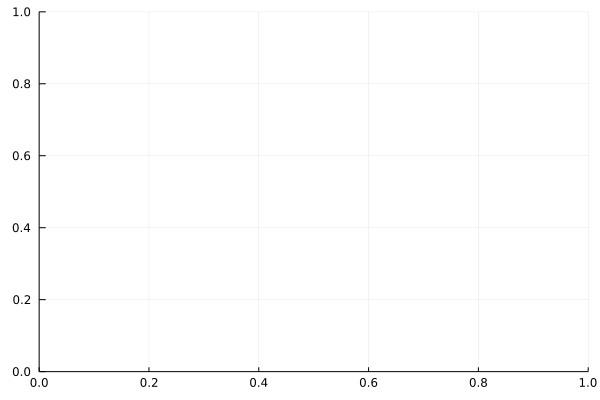

LoadError: Length of x & y does not match the size of z.
Must be either `size(z) == (length(y), length(x))` (x & y define midpoints)
or `size(z) == (length(y)+1, length(x)+1))` (x & y define edges).

In [6]:


for n in 1:len_N_range
    QOT = []
    KNN = []
    for i_prop in 1: len_prop_range
#         ht = heatmap(log.(eps_range), N_range, QOT_accuracies[n, i_prop, :, :], clim=(0.0, 1.0),
#         xlabel= "log(ϵ)", ylabel="Arm", title="N=$(N_range[n]), label% = $(prop_range[i_prop])")
#         push!(QOT, ht)
        
        ht = heatmap(knn_range, N_range, KNN_accuracies[n, i_prop, :, :], clim=(0.0, 1.0),
        xlabel= "neighbours", ylabel="Arm", title="N=$(N_range[n]), label% = $(prop_range[i_prop])")
        push!(KNN, ht)
    end

#     fig = plot(QOT...)
    
#     savefig("../figures/QOT_vs_KNN_noisy/QOT_N=$(N_range[n])")
#     display(fig)
    
    fig = plot(KNN...)
    
#     savefig("../figures/QOT_vs_KNN_noisy/KNN_N=$(N_range[n])")
    display(fig)
end

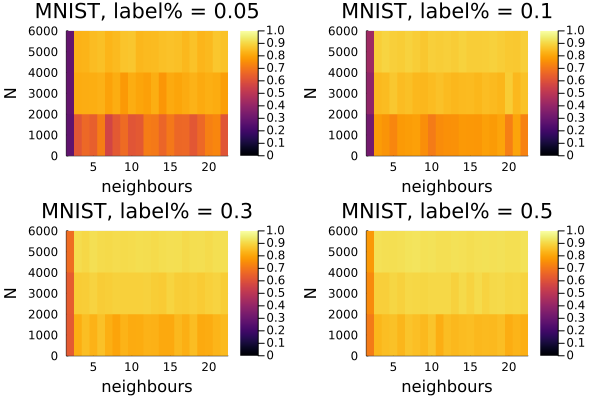

In [8]:


# for k in 1:len_K_range
    QOT = []
    KNN = []
    for i_prop in 1: len_prop_range
#         ht = heatmap(log10.(eps_range), N_range, QOT_accuracies[:, i_prop, :], clim=(0.0, 1.0),
#         xlabel= "log(ϵ)", ylabel="N", title="MNIST, label% = $(prop_range[i_prop])")
#         push!(QOT, ht)
        
        ht = heatmap(knn_range, N_range, KNN_accuracies[:, i_prop, :], clim=(0.0, 1.0),
        xlabel= "neighbours", ylabel="N", title="MNIST, label% = $(prop_range[i_prop])")
        push!(KNN, ht)
    end

#     fig = plot(QOT...)
    
#     savefig("../figures/QOT_vs_KNN_noisy/QOT_Arm=$(K_range[k])")
#     display(fig)
    
    fig = plot(KNN...)
    
#     savefig("../figures/QOT_vs_KNN_noisy/KNN_Arm=$(K_range[k])")
    display(fig)
# end

In [13]:


# for k in 1:len_K_range
    QOT = []
    KNN = []
    for i_prop in 1: len_prop_range
        ht = heatmap(log10.(eps_range), N_range, QOT_accuracies[:, i_prop, :], clim=(0.0, 1.0),
        xlabel= "log(ϵ)", ylabel="N", title="MNIST, label% = $(prop_range[i_prop])")
        push!(QOT, ht)
        
        ht = heatmap(knn_range, N_range, KNN_accuracies[:, i_prop, :], clim=(0.0, 1.0),
        xlabel= "neighbours", ylabel="N", title="MNIST, label% = $(prop_range[i_prop])")
        push!(KNN, ht)
    end

    fig = plot(QOT...)
    
#     savefig("../figures/QOT_vs_KNN_noisy/QOT_Arm=$(K_range[k])")
    display(fig)
    
    fig = plot(KNN...)
    
#     savefig("../figures/QOT_vs_KNN_noisy/KNN_Arm=$(K_range[k])")
    display(fig)
# end

LoadError: BoundsError: attempt to access 5×4×13×21 SharedArray{Float64, 4} at index [1:5, 1, 1:13]

In [14]:
QOT_accuracies

5×4×13×21 SharedArray{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 2, 1] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 3, 1] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

...

[:, :, 11, 1] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 12, 1] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 13, 1] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 1, 2] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 2, 2] =
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0

[:, :, 3, 2] =
 0.0  0.0  0.0